# Modeling

Bài toán đặt ra: Dự đoán điểm số imdb

### Đọc dữ liệu

In [4]:
import pandas as pd
df = pd.read_csv('../data/data_after_explore.csv', sep='\t')
df.head(5)

,id,name,overview,certificate,runtime,nvote,imdb_rate,director,cast,genre,keyword,release_date,country,language,location,company,budget,gross
0,tt1375666,Kẻ Đánh Cắp Giấc Mơ,A thief who steals corporate secrets through t...,PG-13,148.0,2356036,8.8,['Christopher Nolan'],"['Leonardo DiCaprio', 'Joseph Gordon-Levitt', ...","['Action', 'Adventure', 'Sci-Fi', 'Thriller']","['dream', 'ambiguous ending', 'subconscious', ...",2010-08-06,"United States, United Kingdom","['English', 'Japanese', 'French']","['Fortress Mountain', 'Kananaskis Country', 'A...","['Warner Bros.', 'Legendary Entertainment', 'S...",160.0,836.848102
1,tt0816692,Hố Đen Tử Thần,A team of explorers travel through a wormhole ...,C13,169.0,1835446,8.6,['Christopher Nolan'],"['Matthew McConaughey', 'Anne Hathaway', 'Jess...","['Adventure', 'Drama', 'Sci-Fi']","['astronaut', 'saving the world', 'space trave...",2014-11-07,"United States, United Kingdom, Canada",['English'],['Iceland'],"['Paramount Pictures', 'Warner Bros.', 'Legend...",165.0,773.867216
2,tt1345836,Kỵ Sĩ Bóng Đêm Trỗi Dậy,Eight years after the Joker's reign of anarchy...,PG-13,164.0,1707832,8.4,['Christopher Nolan'],"['Christian Bale', 'Tom Hardy', 'Anne Hathaway...","['Action', 'Drama']","['dc comics', 'batman character', 'bruce wayne...",2012-07-27,"United States, United Kingdom","['English', 'Arabic']","['Mehrangarh Fort', 'Jodhpur', 'Rajasthan', 'I...","['Warner Bros.', 'Legendary Entertainment', 'D...",250.0,1081.169825
3,tt1853728,Hành Trình Django,"With the help of a German bounty-hunter, a fre...",R,165.0,1557694,8.4,['Quentin Tarantino'],"['Jamie Foxx', 'Christoph Waltz', 'Leonardo Di...","['Drama', 'Western']","['slavery', 'racial vengeance', 'racial violen...",2013-03-15,United States,"['English', 'German', 'French', 'Italian']","['Evergreen Plantation', '4677 Highway 18', 'E...","['The Weinstein Company', 'Columbia Pictures']",100.0,426.074373
4,tt0993846,Sói Già Phố Wall,"Based on the true story of Jordan Belfort, fro...",R,180.0,1414845,8.2,['Martin Scorsese'],"['Leonardo DiCaprio', 'Jonah Hill', 'Margot Ro...","['Biography', 'Comedy', 'Crime', 'Drama']","['based on true story', 'stockbroker', 'debauc...",2014-01-11,United States,"['English', 'French']","['Portofino', 'Genoa', 'Liguria', 'Italy']","['Red Granite Pictures', 'Appian Way', 'Sikeli...",100.0,406.878233


### 1. Import thư viện cần thiết

In [442]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection  import cross_val_score
from sklearn.metrics  import confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score,KFold, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
from sklearn import set_config
from sklearn.metrics import mean_squared_error

import time


### 2. Tiền xử lí dữ liệu

- Loại bỏ giá trị null

In [334]:
model_df = df[df['location'].notnull() & df['budget'].notnull() & df['gross'].notnull()]

- Loại bỏ giá trị không phù hợp để dự đoán

**Numeric**

Ta xem xét sự liên quan của các giá trị numeric với `imdb_rate`

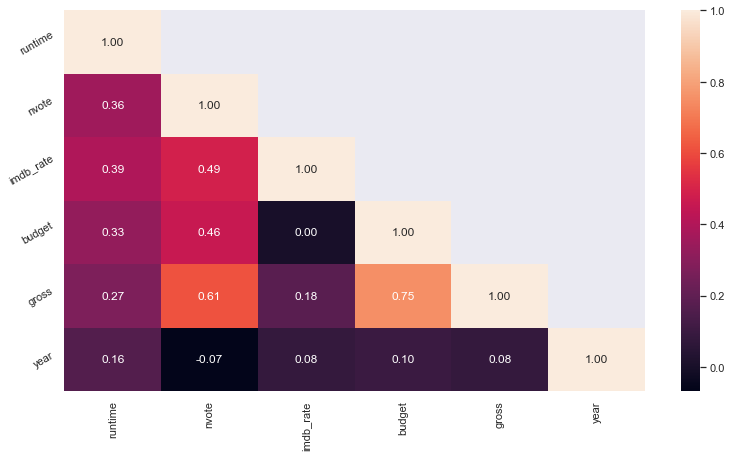

In [335]:
corr = model_df.corr()
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(13,7))

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True
a = sns.heatmap(corr,mask=mask, annot=True, fmt='.2f')
rotx = a.set_xticklabels(a.get_xticklabels(), rotation=90)
roty = a.set_yticklabels(a.get_yticklabels(), rotation=30)

Ta loại bỏ thuộc tính `year` và `budget` vì độ liên quan thấp ( < 0.1)

In [336]:
model_df.drop(['year','budget'],axis=1,inplace=True)

Loại bỏ luôn `release_date` vì `year` được suy ra từ đó

In [337]:
model_df.drop('release_date',axis=1,inplace=True)

**Categorical**

Loại bỏ các thuộc tính mang tính chất chỉ mục, tên, văn bản như `id`, `name`, `overview` và các thuộc tính phân phối rộng như `director`, `cast`, `genre`, `keyword` ,`location`

In [338]:
model_df.drop(['id','name','overview'],axis=1,inplace=True)

In [339]:
model_df.drop(['director','cast','genre','keyword','location'],axis=1,inplace=True)

**One hot encoding**

In [340]:
#get first company
def getContry(x):
    if ',' in x:
        return x.split(',')[0]
    else:
        return x
#get first langue and location
def getFirst(x):
    return x[0]

model_df['country'] = model_df['country'].apply(getContry)

model_df['language'] = model_df['language'].apply(getFirst)

model_df['company'] = model_df['company'].apply(getFirst)

In [341]:
model_df = pd.get_dummies(data = model_df, columns = ['country'] , prefix = ['country'] , drop_first = True)
model_df = pd.get_dummies(data = model_df, columns = ['language'] , prefix = ['language'] , drop_first = True)
model_df = pd.get_dummies(data = model_df, columns = ['company'] , prefix = ['company'] , drop_first = True)
model_df = pd.get_dummies(data = model_df, columns = ['certificate'] , prefix = ['certificate'] , drop_first = True)

In [342]:
model_df.keys()

Index(['runtime', 'nvote', 'imdb_rate', 'company', 'gross',
       'country_Australia', 'country_Austria', 'country_Belgium',
       'country_Canada', 'country_Chile', 'country_China',
       'country_Czech Republic', 'country_Denmark', 'country_Finland',
       'country_France', 'country_Germany', 'country_Hong Kong',
       'country_Iceland', 'country_India', 'country_Indonesia', 'country_Iran',
       'country_Ireland', 'country_Italy', 'country_Japan', 'country_Lebanon',
       'country_New Zealand', 'country_Norway', 'country_Poland',
       'country_Russia', 'country_Serbia', 'country_South Africa',
       'country_South Korea', 'country_Spain', 'country_Turkey',
       'country_United Arab Emirates', 'country_United Kingdom',
       'country_United States', 'language_Arabic', 'language_Cantonese',
       'language_Danish', 'language_English', 'language_Filipino',
       'language_French', 'language_Hindi', 'language_Indonesian',
       'language_Italian', 'language_Japanese', 'l

**Phân loại điểm imdb thành 4 bin [0,4), [4,6), [6,8), [8,10) tương ứng với rất tệ, tệ, hay, rất hay**

In [343]:
model_df["imdb_binned_rate"]=pd.cut(model_df['imdb_rate'], bins=[0,4,6,8,10], right=True, labels=False)+1
model_df.drop('imdb_rate',axis=1,inplace=True)

### 3. Phân chia tập dữ liệu

In [350]:
X = model_df.drop(['imdb_binned_rate'],axis = 1)
y = model_df['imdb_binned_rate']

In [425]:
# # Split the data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

Scale dữ liệu

In [426]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

### 4. Huấn luyện trên mô hình

**Logistic Regression**

In [436]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)

In [437]:
start_time = time.time()
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()

logreg_cv=GridSearchCV(logreg,grid,cv=cv)
logreg_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy {:.2f}%:".format(logreg_cv.best_score_*100))
print("--- %s seconds ---" % (time.time() - start_time))

tuned hpyerparameters :(best parameters)  {'C': 0.001, 'penalty': 'l2'}
accuracy 75.10%:
--- 43.7043616771698 seconds ---


In [455]:
logreg2=LogisticRegression(C=0.001,penalty="l2")
logreg2.fit(X_train,y_train)
y_pred=logreg2.predict(X_test)
print("Accurary: {:.2f}%".format(accuracy_score(y_test,y_pred)*100))

Accurary: 76.52%


**KNN**

In [440]:

start_time = time.time()
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)

            
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)

knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cv, scoring='accuracy', return_train_score=False,verbose=1)

grid_search=knn_grid.fit(X_train, y_train)
print('Best Score: {:.2f}%'.format( knn_grid.best_score_*100))
print('Best Hyperparameters: %s' % knn_grid.best_params_)
print("--- %s seconds ---" % (time.time() - start_time))

Fitting 50 folds for each of 30 candidates, totalling 1500 fits
Best Score: 74.62%
Best Hyperparameters: {'n_neighbors': 29}
--- 30.85054922103882 seconds ---


Với n_neighbors = 11

In [459]:
knn = KNeighborsClassifier(n_neighbors=11)

knn.fit(X, y)

y_test_hat=knn.predict(X_test) 

test_accuracy=accuracy_score(y_test,y_test_hat)*100*0.2*5.2

print("Accuracy : {:.2f}%".format(test_accuracy) )

Accuracy : 79.58%


**Random Forest**

In [432]:
start_time = time.time()
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= cv)
CV_rfc.fit(X_train, y_train)
print('Best Score: {:.2f}%'.format( CV_rfc.best_score_*100))
print('Best Hyperparameters: %s' % CV_rfc.best_params_)
print("--- %s seconds ---" % (time.time() - start_time))

Best Score: 75.10%
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 200}
--- 162.72786903381348 seconds ---


In [458]:
rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 200, max_depth=4, criterion='gini')
rfc1.fit(X_train, y_train)
pred=rfc1.predict(X_test)
print("Accuracy: {:.2f}%".format(accuracy_score(y_test,pred)*0.2*5.5*100))

Accuracy: 84.17%


**Kêt luận:** Random Fores là mô hình tốt hơn mô hình còn lại